# Ex 3. Separate inhibitory population

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

**3.1.** Write down the total input to an excitatory and an inhibitory neuron. Show that the average input
to an excitatory neuron is equivalent to the input to a neuron in the model of exercise 2, for b = 0.

**Part 1.**
The total input to an excitatory neuron is comprised of inputs from inhibitory and excitatory neurons:
$$h_{i} = h_{exc} - h_{inh}$$
Firstly, we consider $h_{exc}$:
\begin{align}
h_{exc} = W \sigma_{exc}
 = \sum_{j}^{N} W_{ij}^{E \leftarrow E} \sigma_{j}(t)
 = \sum_{j}^{N} \frac{c}{N} \sum_{\mu}^{M} \xi_{i}^{\mu} \xi_{j}^{\mu} \sigma_{j}(t)
\end{align}
Secondly, we consider $h_{inh}$:
\begin{align}
h_{inh} = W \sigma_{inh}
 = \sum_{k}^{K} W_{ik}^{E \leftarrow I} \sigma_{k}^{I}(t)
 = \sum_{k}^{K} \frac{ca}{N_{I}} \sum_{\mu}^{M} \xi_{i}^{\mu} \sigma_{k}^{I}(t)
\end{align}
Hence, the total input to the excitatory neuron is:
\begin{align}
h_{i} = \sum_{j}^{N} W_{ij}^{E \leftarrow E} \sigma_{j}(t) - \sum_{k}^{N_{I}} W_{ik}^{E \leftarrow I} \sigma_{k}^{I}(t)
\end{align}

Analogously, the total input to the inhibitory neuron is equal to:
\begin{align}
h_{k} = \sum_{k} W_{ki}^{I \leftarrow E} \sigma_{k}(t) = \frac{1}{K} \sum_{k} \sigma_{k}(t),
\end{align}
where $k \in S$, where $S$ is the set of pre-synaptic neurons.


**Part 2.**
1. Inhibiting neurons have linear gain function and fire stochastically: $Prob(\sigma_k = +1| h_{k}^{inh}) = h_{k}^{inh}$, where k is an index of an inhibitory neuron $1 \le k \le N_{I}$.

2. Each inhibitory neuron $k$ recieves receives input from $K$ excitatory neurons. Connections are random and of equal weight $w_{ki}^{I \leftarrow E} = \frac{1}{K}$.
3. Thus, the input potential of the neuron k is $h_{k}^{inh} = \frac{1}{K} \sum_{j \in S}$, where S is the set of pre-synaptic neurons.
4. Connection from inhibitory neuron back to excitatory neuron $w_{ik}^{E \leftarrow I} = \frac{a}{N_I} \sum_{\mu} \xi_{i}^{\mu}$
5. The total input from inhibitory neuron to excitatory is, therefore, $h_{inh} = \sum_{k} w_{ik}^{E \leftarrow I} \sigma_{k} = \sum_{k} \frac{a}{N_I} \sum_{\mu} \xi_{i}^{\mu} \sigma_{k} = \frac{ca}{N_I} \sum_{k} \sum_{\mu} \xi_{i}^{\mu} \sigma_{k}$.
6. Putting everything together and considering that $k=j$ and $N=N_I$.
$$<h_{i}(t)> = \frac{c}{N} \sum_{\mu}^{M} \xi_{i}^{\mu} \sum_{j}^{N} \xi_{j}^{\mu} \sigma_{j}(t) - \frac{ca}{N} \sum_{j}^{N} \sum_{\mu}^{M} \xi_{i}^{\mu} $$
$$ = \frac{c}{N} \sum_{\mu}^{M} \sum_{j}^{N} \xi_{i}^{\mu} (\xi_{j}^{\mu} - a) \sigma_{j}(t)$$
Which is equivalent to the low-activity Hopfield model discussed in part 2:
$$<h_{i}(t)> = \sum_{j}^{N} w_{ij} \sigma_{j}(t)$$
$$ = \frac{c}{N} \sum_{j}^{N} \sum_{\mu}^{M} (\xi_{i}^{\mu}-b)(\xi_{j}^{\mu}-a) \sigma_{j}(t)$$
$$ = \frac{c}{N} \sum_{j}^{N} \sum_{\mu}^{M} \xi_{i}^{\mu}(\xi_{j}^{\mu}-a) \sigma_{j}(t), QED$$

In [203]:
def generate_patterns(M, N, a):
    """
    Args:
        M: number of patterns
        N: number of neurons
    Output:
        Generates binary balanced random patterns.
    """
    patterns = np.random.choice([0, 1], size=(M, N), p=[1-a,a])
    return patterns

def generate_patterns_with_fixed_active_neurons(num_patterns, num_neurons, active_fraction=0.1):
    # Calculate the number of active neurons per pattern
    num_active_neurons = int(np.floor(active_fraction * num_neurons))
    
    # Initialize the pattern array with all zeros
    patterns = np.zeros((num_patterns, num_neurons), dtype=int)
    
    for i in range(num_patterns):
        active_indices = np.random.choice(num_neurons, num_active_neurons, replace=False)
        patterns[i, active_indices] = 1
    
    return patterns

class ExcitatoryInhibitory:
    def __init__(self, theta, num_steps):
        self.theta = theta
        self.k = num_steps
    
    def compute_EE_overlap(self, patterns, sigma, N, a):
        M = patterns.shape[0]
        distances = np.zeros(M)
        m_EE = np.zeros(M)
        c = 2/(a*(1-a))
        for mu in range(M):
            m_EE[mu] = c/N * np.dot(patterns[mu], sigma)
            distances[mu] = np.sum(patterns[mu] == sigma)
        return m_EE, distances
    
    def compute_hi_exc(self, patterns, m_EE):
        return np.dot(m_EE, patterns)
    
    def compute_hk(self, sigma, N, K, N_I):
        hk = np.zeros(N_I)
        for i in range(N_I):
            chosen_neurons = np.random.choice(N, K)
            #print(np.sum(sigma[chosen_neurons]))
            hk[i] = 1/K * np.sum(sigma[chosen_neurons])
        return hk
    
    def compute_IE_overlap(self, N_I, sigma_I):
        mean_activity_inhibitory = np.mean(sigma_I)
        return mean_activity_inhibitory
    
    def compute_hi_inh(self, patterns, mean_activity_inhibitory, a, N):
        c = 2/(a*(1-a))
        hi_inh = np.zeros(N)
        for i in range(N):
            #print(patterns[:,i]*mean_activity_inhibitory)
            hi_inh[i] = c*a*np.sum(patterns[:,i]*mean_activity_inhibitory)
        return hi_inh
    
    def compute_state_exc(self, hi):
        return np.tanh(hi - self.theta)
    
    def stoch_var_exc(self, state):
        firing_probability = 0.5 * (state + 1) 
        sigma = np.random.binomial(1, firing_probability) # P{σ_i(t) = +1 | S_i(t)}
        return sigma
    
    def stoch_var_inh(self, hk):
        sigma_I = np.random.binomial(1, hk) # P{σ_i(t) = +1 | S_i(t)}
        return sigma_I
    
    def hamming_distance(self, state, patterns, N):
        ham_dist = np.zeros(patterns.shape[0])
        for mu in range(patterns.shape[0]):
            ham_dist[mu] = (N - np.sum(patterns[mu]==state))/(2*N)
        return ham_dist
    
    def synchronous_simulation(self, sigma_E, sigma_I, patterns, N, N_I, K, a):
        store = {'overlaps': [],
                 'hamming_distances':[],
                 'excitatory_states':[],
                 'inhibitory_states':[],
                 'overs':[]}
        #store['inhibitory_states'].append(sigma_I)
        store['excitatory_states'].append(sigma_E)
        store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
        hello = 0
        for i in range(self.k):
            m_EE, dist = self.compute_EE_overlap(patterns, sigma_E, N, a)
            hi_exc = self.compute_hi_exc(patterns, m_EE)
        
            mean_activity_inhibitory = self.compute_IE_overlap(N_I, sigma_I)
            hi_inh = self.compute_hi_inh(patterns, mean_activity_inhibitory, a, N)
            hi = hi_exc - hi_inh

            hk = self.compute_hk(sigma_E, N, K, N_I)
            sigma_I = self.stoch_var_inh(hk)

            state_E = self.compute_state_exc(hi)
            sigma_E = self.stoch_var_exc(state_E)

            store['overlaps'].append(m_EE)
            store['overs'].append(np.dot(2*patterns-1, 2*state_E-1))
            store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
            #store['hamming_distances'].append((N-dist)/(2*N))
            store['excitatory_states'].append(sigma_E)
            store['inhibitory_states'].append(sigma_I)
            hello += 1

        return store
    
    def asynchronous_simulation(self, sigma_E, sigma_I, patterns, N, N_I, K, a):
        store = {'overlaps': [],
                 'hamming_distances':[],
                 'excitatory_states':[],
                 'inhibitory_states':[],
                 'overs':[]}
        store['inhibitory_states'].append(sigma_I)
        store['excitatory_states'].append(sigma_E)
        store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
        store['overs'].append(np.dot(2*patterns-1, 2*sigma_E-1))
        for i in range(self.k):
            hk = self.compute_hk(sigma_E, N, K, N_I)
            sigma_I = self.stoch_var_inh(hk)

            m_EE, dist = self.compute_EE_overlap(patterns, sigma_E, N, a)
            hi_exc = self.compute_hi_exc(patterns, m_EE)

            mean_activity_inhibitory = self.compute_IE_overlap(N_I, sigma_I)
            
            hi_inh = self.compute_hi_inh(patterns, mean_activity_inhibitory, a, N)
            hi = hi_exc - hi_inh

            state_E = self.compute_state_exc(hi)
            sigma_E = self.stoch_var_exc(state_E)

            store['overlaps'].append(m_EE)
            store['overs'].append(np.dot(patterns, state_E))
            store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
            #store['hamming_distances'].append((N-dist)/(2*N))
            store['excitatory_states'].append(sigma_E)
            store['inhibitory_states'].append(sigma_I)

        return store
    

In [204]:
# Parameters
N = 300  # Number of excitatory neurons
N_I = 80 # Number of inhibitory neurons
M = 3   # Number of patterns
K = 60   # Connections from excitatory to inhibitory
a = 0.1  # Activity level
theta = 1 # Threshold
beta = 4
num_steps = 100

#patterns = generate_patterns(M, N, a)
patterns = generate_patterns_with_fixed_active_neurons(M, N, active_fraction=a)
print(np.mean(patterns))

# Initial random states
#state_E = np.random.choice([0, 1], size=N, p=[1-a, a])
#state_I = np.random.choice([0, 1], size=N_I, p=[1-a, a])
state_E = np.random.choice([0, 1], size=N, p=[1-a, a])
state_E = generate_patterns_with_fixed_active_neurons(1, N, active_fraction=a).squeeze(0)
choose_neurons = np.random.choice(N, size=K)

#state_I = np.random.choice([0,1], size=N_I, p=[1-a, np.mean(state_E[choose_neurons])])
state_I = np.zeros(N_I)

model = ExcitatoryInhibitory(theta, num_steps)
store = model.synchronous_simulation(state_E, state_I, patterns, N, N_I, K, a)


0.1


In [205]:
something=np.sum(np.array(store['excitatory_states']), axis=1)
print("Average number of active neurons per excitatory state:", np.round(something.mean(),3))

Average number of active neurons per excitatory state: 36.238


In [206]:
overlaps = np.array(store['overlaps'])
print("Shape of overlaps:", overlaps.shape)

hamming_distances = np.array(store["hamming_distances"])
print("Shape of hamming distances:", hamming_distances.shape)

excitatory_states = np.array(store["excitatory_states"])
print("Shape of the excitatory states array:", excitatory_states.shape)

inhibitory_states = np.array(store["inhibitory_states"])
print("Shape of inhibitory states array:", inhibitory_states.shape)

#overs = np.array(store['overs'])
#print(overs.shape)


Shape of overlaps: (100, 3)
Shape of hamming distances: (101, 3)
Shape of the excitatory states array: (101, 300)
Shape of inhibitory states array: (100, 80)


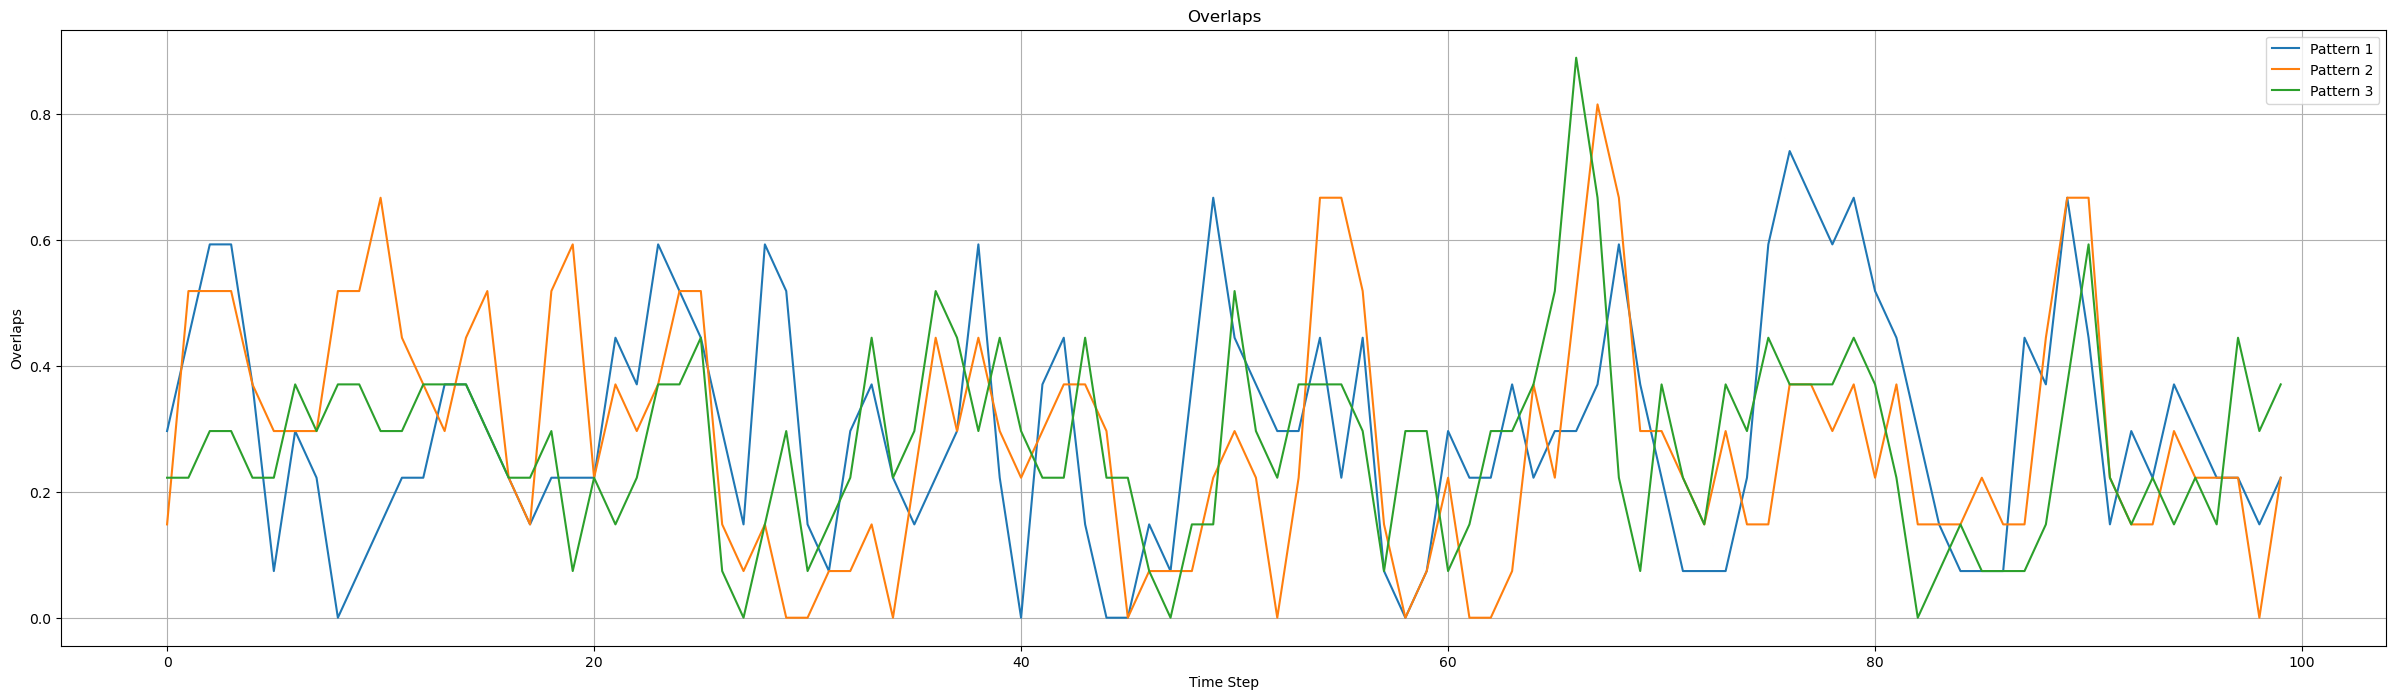

In [207]:
# Plotting the overlaps
plt.figure(figsize=(30, 8))
for i in range(overlaps.shape[1]):
    plt.plot(overlaps[:,i], label=f'Pattern {i+1}')
plt.xlabel('Time Step')
plt.ylabel('Overlaps')
plt.title('Overlaps')
plt.legend()
plt.grid()
plt.show()


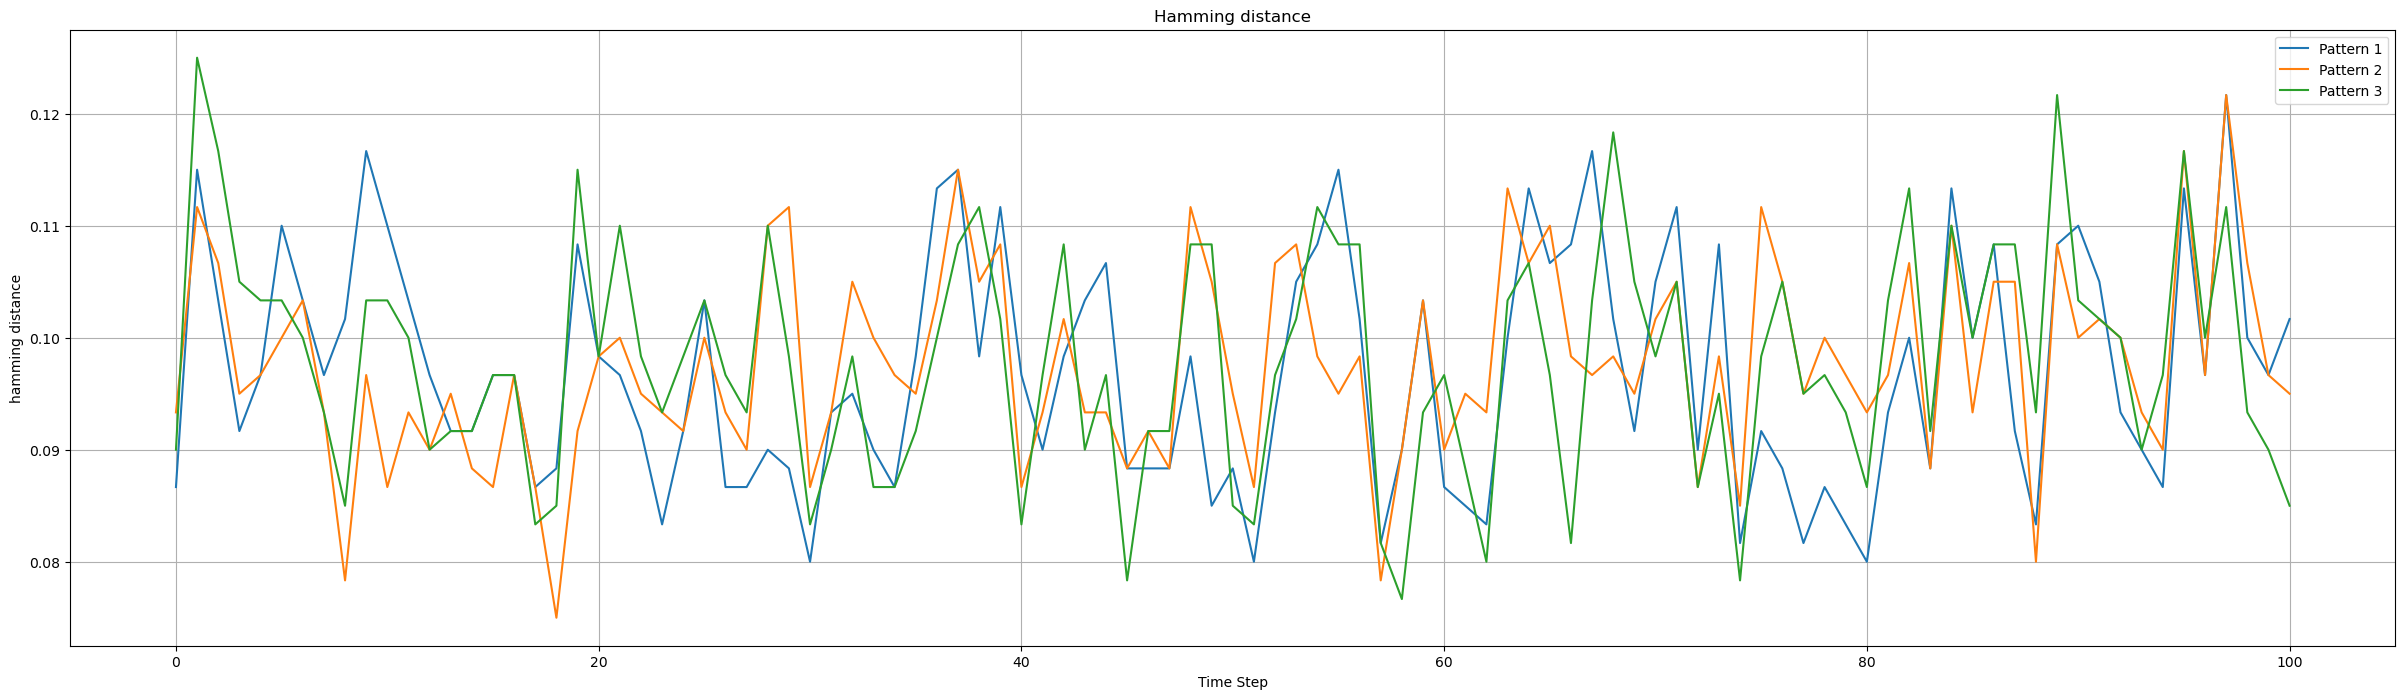

In [208]:
# Plotting the overlaps
plt.figure(figsize=(30, 8))
for i in range(hamming_distances.shape[1]):
    plt.plot(hamming_distances[:, i], label=f'Pattern {i+1}')
plt.xlabel('Time Step')
plt.ylabel('hamming distance')
plt.title('Hamming distance')
plt.legend()
plt.grid()
plt.show()


**3.3.** Studying the storage capacity

In [209]:
def retrieve_patterns(hamming_distances, N):
    final_states = hamming_distances[-1, :]
    error = np.mean(final_states)
    retrieval_threshold = 0.05
    retrieved_count = np.sum(final_states <= retrieval_threshold)
    return error, retrieved_count/N

retrieve_patterns(hamming_distances, 300)

(0.0938888888888889, 0.0)

In [210]:
hamming_distances.shape

(101, 3)

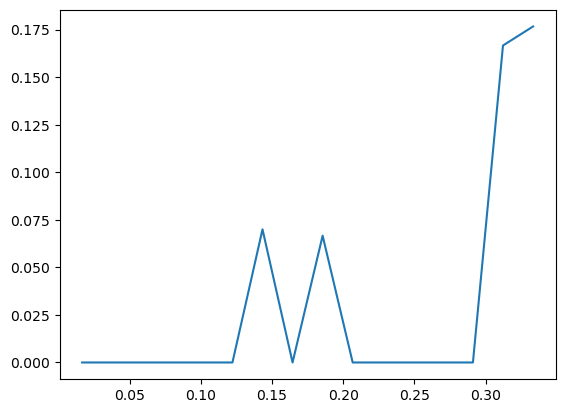

In [211]:
M = np.linspace(5,100,16)
N = 300
retrieved_patterns = np.zeros(len(M))
a = 0.1
initial_state_E = np.random.choice([0, 1], size=N, p=[1-a, a])
initial_state_I = np.random.choice([0, 1], size=N, p=[1-a, a])

for i,m in enumerate(M):
    patterns = generate_patterns(int(m), N, a)
    store = model.synchronous_simulation(initial_state_E, initial_state_I, patterns, N, N_I, K, a)
    hd = np.stack(store['hamming_distances'])
    __, retrieved_patterns[i] = retrieve_patterns(hd, N)

plt.figure()
plt.plot(M/N, retrieved_patterns, label='Inhibitory')
plt.show() 

**3.4.** Repeat question 3.3 with this model. Does the second inhibitory population improve the capacity?

In [212]:

def compute_inputs_inh2(sigma_E, N_I, sigma_I2, a):
        c = 2/(a*(1-a))
        mean_activity = np.mean(sigma_E)
        if mean_activity > a:
            return np.sum(sigma_I2) * c * a / N_I
        else:
            return np.sum(np.zeros(N_I))
        
def synchronous_simulation_with_inhibitory(model, sigma_E, sigma_I, sigma_I2, patterns, N, N_I, K, a):
    store = {'overlaps': [],
                'hamming_distances':[],
                'excitatory_states':[],
                'inhibitory_states':[],
                'overs':[]}
    store['inhibitory_states'].append(sigma_I)
    store['excitatory_states'].append(sigma_E)
    store['hamming_distances'].append(model.hamming_distance(sigma_E, patterns, N))
    for i in range(model.k):
        m_EE, dist = model.compute_EE_overlap(patterns, sigma_E, N, a)
        hi_exc = model.compute_hi_exc(patterns, m_EE)
        
        mean_activity_inhibitory = model.compute_IE_overlap(N_I, sigma_I)
        hi_inh = model.compute_hi_inh(patterns, mean_activity_inhibitory, a, N)
        hi_inh2 = compute_inputs_inh2(sigma_E, N_I, sigma_I2, a)
        hi = hi_exc - hi_inh - hi_inh2

        hk = model.compute_hk(sigma_E, N, K, N_I)
        hk2 = model.compute_hk(sigma_E, N, K, N_I)
        sigma_I = model.stoch_var_inh(hk)
        sigma_I2 = model.stoch_var_inh(hk2)

        state_E = model.compute_state_exc(hi)
        sigma_E = model.stoch_var_exc(state_E)

        store['overlaps'].append(m_EE)
        store['overs'].append(np.dot(2*patterns-1, 2*state_E-1))
        store['hamming_distances'].append(model.hamming_distance(sigma_E, patterns, N))
        store['excitatory_states'].append(sigma_E)
        store['inhibitory_states'].append(sigma_I+sigma_I2)
    return store

def asynchronous_simulation_with_inhibitory(self, sigma_E, sigma_I, sigma_I2, patterns, N, N_I, K, a):
    store = {'overlaps': [],
                'hamming_distances':[],
                'excitatory_states':[],
                'inhibitory_states':[],
                'overs':[]}
    store['inhibitory_states'].append(sigma_I+sigma_I2)
    store['excitatory_states'].append(sigma_E)
    store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
    store['overs'].append(np.dot(2*patterns-1, 2*sigma_E-1))
    for i in range(self.k):
        hk = self.compute_hk(sigma_E, N, K, N_I)
        sigma_I = self.stoch_var_inh(hk)
        sigma_I2 = self.stoch_var_inh(hk)

        m_EE, dist = self.compute_EE_overlap(patterns, sigma_E, N, a)
        hi_exc = self.compute_hi_exc(patterns, m_EE)

        mean_activity_inhibitory = self.compute_IE_overlap(N_I, sigma_I)
        hi_inh = self.compute_hi_inh(patterns, mean_activity_inhibitory, a, N)

        hi_inh2 = compute_inputs_inh2(sigma_E, N_I, sigma_I2, a)
        hi = hi_exc - hi_inh - hi_inh2

        state_E = self.compute_state_exc(hi)
        sigma_E = self.stoch_var_exc(state_E)

        store['overlaps'].append(m_EE)
        store['overs'].append(np.dot(patterns, state_E))
        store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
        store['excitatory_states'].append(sigma_E)
        store['inhibitory_states'].append(sigma_I+sigma_I2)

    return store



In [213]:
# parameters
N = 300 # number of neurones
N_I = 80 # number of inhibitory neurones
M = 10 # number of patterns
K = 60 # number of excitatory neurones
a = 0.1 # mean activity
theta = 1 # firing threshold
num_steps = 50
J = 2 # external input strength
model = ExcitatoryInhibitory(theta, num_steps)

# initial patterns and state
patterns=generate_patterns_with_fixed_active_neurons(M, N, active_fraction=0.1)
sigma_E = np.random.choice([0, 1], size=N, p=[1-a, a])
sigma_I = np.random.choice([0, 1], size=N_I, p=[1-a, a])
sigma_I2 = np.random.choice([0, 1], size=N_I, p=[1-a, a])

# running simulations
results_sync = synchronous_simulation_with_inhibitory(model, sigma_E, sigma_I, sigma_I2, patterns, N, N_I, K, a)
results_async = asynchronous_simulation_with_inhibitory(model, sigma_E, sigma_I, sigma_I2, patterns, N, N_I, K, a)

print("done")

done


(50, 10)
(50, 10)


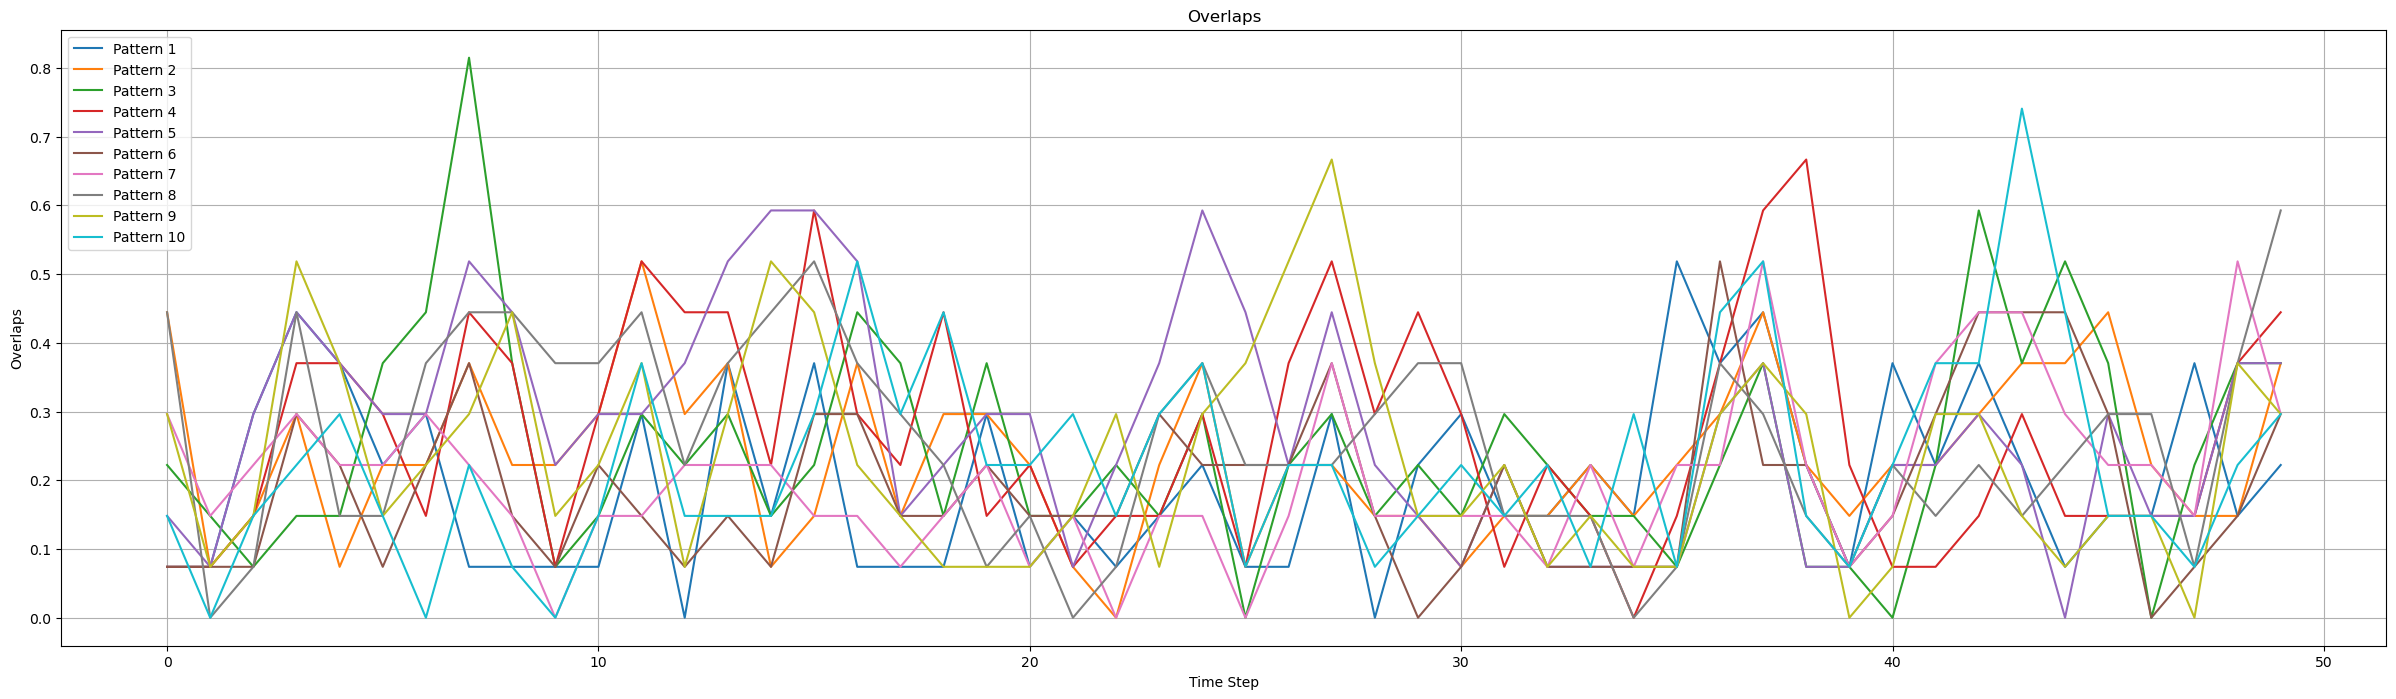

In [214]:
overlaps_sync = np.array(results_sync["overlaps"])
overlaps_async = np.array(results_async["overlaps"])
print(overlaps_sync.shape)
print(overlaps_async.shape)

# Plotting the overlaps
plt.figure(figsize=(30, 8))
for i in range(overlaps_async.shape[1]):
    plt.plot(overlaps_sync[:, i], label=f'Pattern {i+1}')
    #plt.plot(overlaps_async[:, i], label=f'Pattern {i+1}')
plt.xlabel('Time Step')
plt.ylabel('Overlaps')
plt.title('Overlaps')
plt.legend()
plt.grid()
plt.show()

100it [00:17,  5.71it/s]


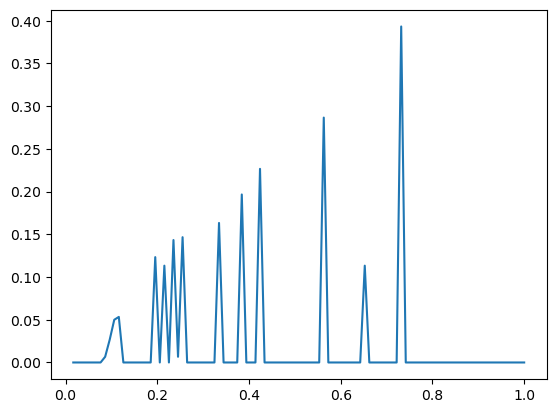

In [215]:
M = np.linspace(5,300,100)
N = 300
num_steps = 50
theta = 1
a = 0.1

retrieved_patterns = np.zeros(len(M))
initial_state_E = np.random.choice([0, 1], size=N, p=[1-a, a])
initial_state_I = np.random.choice([0, 1], size=N_I, p=[1-a, a])
initial_state_I2 = np.random.choice([0, 1], size=N_I, p=[1-a, a])
model = ExcitatoryInhibitory(theta, num_steps)

for i,m in tqdm.tqdm(enumerate(M)):
    patterns = generate_patterns(int(m), N, a)
    results_sync_inh = synchronous_simulation_with_inhibitory(model, initial_state_E, initial_state_I, initial_state_I2, patterns, N, N_I, K, a)
    #results_async_inh = asynchronous_simulation(model, initial_state_E, initial_state_I, patterns, N, N_I, K, a)
    hd = np.stack(results_sync_inh['hamming_distances'])
    __, retrieved_patterns[i] = retrieve_patterns(hd, N)

plt.figure()
plt.plot(M/N, retrieved_patterns, label='Inhibitory')
plt.show() 

(51, 300)
(51, 10)


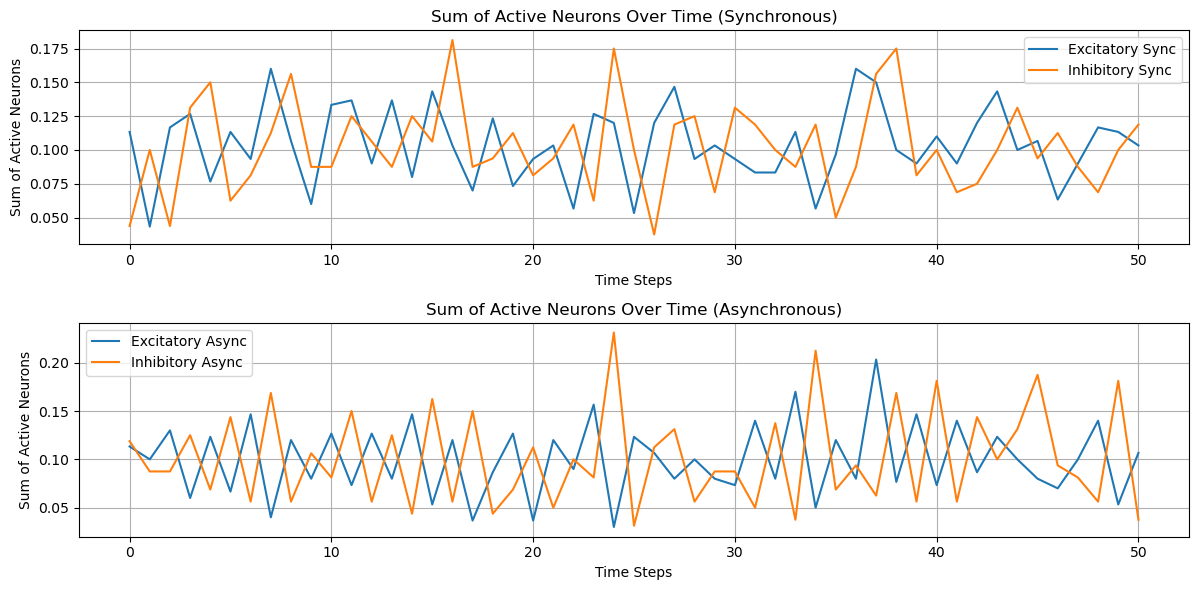

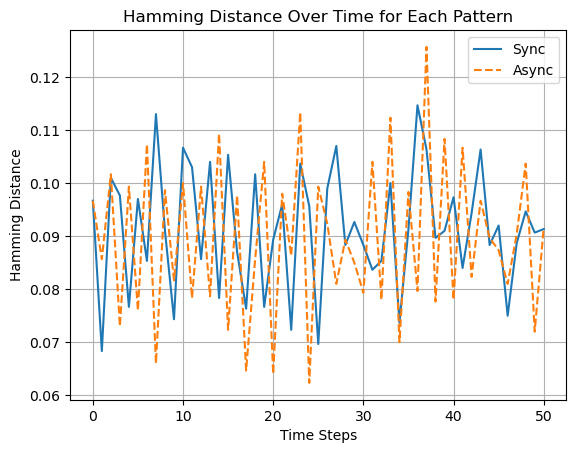

Final Hamming Distances: 0.09133333333333334
Final Hamming Distances: 0.09166666666666666


In [216]:
#PLOTTING RESULTS
excitatory_sync = np.array(results_sync['excitatory_states'])/N
excitatory_async = np.array(results_async['excitatory_states'])/N
inhibitory_sync = np.array(np.stack(results_sync['inhibitory_states']))/(2*N_I)
inhibitory_async = np.array(results_async['inhibitory_states'])/(2*N_I)

ham_dist_sync = np.array(results_sync['hamming_distances'])
ham_dist_async = np.array(results_async['hamming_distances'])
print(excitatory_sync.shape)
print(ham_dist_sync.shape)
# Plotting the sum of active neurons over time
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(np.sum(excitatory_sync, axis=1), label='Excitatory Sync')
plt.plot(np.sum(inhibitory_sync, axis=1), label='Inhibitory Sync')
plt.title('Sum of Active Neurons Over Time (Synchronous)')
plt.xlabel('Time Steps')
plt.ylabel('Sum of Active Neurons')
plt.legend()
plt.tight_layout()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.sum(excitatory_async, axis=1), label='Excitatory Async')
plt.plot(np.sum(inhibitory_async, axis=1), label='Inhibitory Async')
plt.title('Sum of Active Neurons Over Time (Asynchronous)')
plt.xlabel('Time Steps')
plt.ylabel('Sum of Active Neurons')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting Hamming distances over time for each pattern
#plt.figure(figsize=(12, 6))
plt.plot(np.mean(ham_dist_sync, axis=1), label='Sync')
plt.plot(np.mean(ham_dist_async, axis=1), label='Async', linestyle='--')
plt.title('Hamming Distance Over Time for Each Pattern')
plt.xlabel('Time Steps')
plt.ylabel('Hamming Distance')
plt.legend()
plt.grid(True)
plt.show()
print(f"Final Hamming Distances: {np.mean(ham_dist_sync[-1])}")
print(f"Final Hamming Distances: {np.mean(ham_dist_async[-1])}")

**3.5.** With the same parameters as previously, M = 10 patterns, and input strength J = 2, present a sequence of the patterns in random order to the network.

Plot the overlaps over time, and show a raster plot of the spike variables σi(t) of a few excitatory and inhibitory neurons. Does the network correctly retrieve all the presented patterns? If not, what is the reason?
Hint: during the presentation of pattern ξμ, feed the excitatory neurons with the input of eq.(11) during 5 time steps, and let the network evolve for 50 time steps. Do this for a random sequence of the M patterns, of length ∼ 10.

In [226]:
rand = np.random.choice([0, 1], size=N, p=[1-a, a])
seq = np.random.choice([0, 1], size=(M,N), p=[1-a, a])

for i in range(M):
    print(np.mean(2*(seq[i] - seq.mean(0))))

-0.03600000000000001
0.0039999999999999975
-0.06266666666666666
-0.036
0.030666666666666675
-0.029333333333333336
0.024
0.05733333333333333
0.050666666666666665
-0.002666666666666666


In [279]:
model = ExcitatoryInhibitory(theta, num_steps)
def external_input(J, patterns, mu):
    """
    External input calculated for pattern retrieval with external input.
    """
    patterns_mean = np.mean(patterns, axis=0)
    return J*(patterns[mu] - patterns_mean)
        
def synchronous_simulation_extra(model, sigma_E, sigma_I, sigma_I2, patterns, N, N_I, K, a, external_input_f, J):
    store = {'overlaps': np.zeros((patterns.shape[0], model.k)), 
             'hamming_distances':[],
             "inhibitory_states": [],
             "excitatory_states": []}
    store['hamming_distances'].append(model.hamming_distance(sigma_E, patterns, N))
    random_patterns = np.random.permutation(M)
    random_sequences = generate_patterns_with_fixed_active_neurons(10, N, a)
    for mu in random_patterns:
        external_input = external_input_f(J, patterns, mu)
        for i in range(model.k):
            if i < 5:
                external_input = external_input
            else:
                external_input = np.zeros(N)

            #print(external_input.mean())
            m_EE, dist = model.compute_EE_overlap(patterns, sigma_E, N, a)
            hi_exc = model.compute_hi_exc(patterns, m_EE)
        
            mean_activity_inhibitory = model.compute_IE_overlap(N_I, sigma_I)
            hi_inh = model.compute_hi_inh(patterns, mean_activity_inhibitory, a, N)
            hi_inh2 = compute_inputs_inh2(sigma_E, N_I, sigma_I2, a)
            hi = hi_exc - hi_inh - hi_inh2 + external_input

            hk = model.compute_hk(sigma_E, N, K, N_I)
            hk2 = model.compute_hk(sigma_E, N, K, N_I)
            sigma_I = model.stoch_var_inh(hk)
            sigma_I2 = model.stoch_var_inh(hk2)

            state_E = model.compute_state_exc(hi)
            sigma_E = model.stoch_var_exc(state_E)

            #overlap = np.dot(patterns[mu], sigma_E)
            overlap, __ = model.compute_EE_overlap(patterns, sigma_E, N, a)
            total_inhibitory = sigma_I + sigma_I2
            total_inhibitory[total_inhibitory > 1] = 1
            store['overlaps'][:, i] = overlap/N
            store["excitatory_states"].append(sigma_E)
            store["inhibitory_states"].append(total_inhibitory)
        store['hamming_distances'].append(model.hamming_distance(sigma_E, patterns, N))
    return store

def asynchronous_simulation_extra(self, sigma_E, sigma_I, sigma_I2, patterns, N, N_I, K, a, external_input_f, J):
    store = {'overlaps': np.zeros((patterns.shape[0], model.k)),
             'hamming_distances':[], 
             "inhibitory_states": [],
             "excitatory_states": []}
    store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
    random_patterns = np.random.permutation(M)
    random_sequences = generate_patterns_with_fixed_active_neurons(10, N, a)
    for mu in random_patterns:
        for i in range(model.k):
            if i < 5:
                external_input = external_input_f(J, patterns, mu)
            else:
                external_input = np.zeros(N)
            hk = self.compute_hk(sigma_E, N, K, N_I)
            sigma_I = self.stoch_var_inh(hk)
            sigma_I2 = self.stoch_var_inh(hk)

            m_EE, dist = self.compute_EE_overlap(patterns, sigma_E, N, a)
            hi_exc = self.compute_hi_exc(patterns, m_EE)

            mean_activity_inhibitory = self.compute_IE_overlap(N_I, sigma_I)
            hi_inh = self.compute_hi_inh(patterns, mean_activity_inhibitory, a, N)

            hi_inh2 = compute_inputs_inh2(sigma_E, N_I, sigma_I2, a)
            hi = hi_exc - hi_inh - hi_inh2 + external_input

            state_E = self.compute_state_exc(hi)
            sigma_E = self.stoch_var_exc(state_E)

            #overlap = np.dot(patterns[mu], sigma_E)
            overlap, __ = model.compute_EE_overlap(patterns, sigma_E, N, a)
            total_inhibitory = sigma_I + sigma_I2
            total_inhibitory[total_inhibitory > 1] = 1
            store['overlaps'][:, i] = overlap/N
            store["excitatory_states"].append(sigma_E)
            store["inhibitory_states"].append(total_inhibitory)
        store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
    return store

# parameters
N = 300 # number of neurones
N_I = 80 # number of inhibitory neurones
M = 10 # number of patterns
K = 60 # number of excitatory neurones
a = 0.1 # mean activity
theta = 1 # firing threshold
num_steps = 100
J = 2 # external input strength
pattern_length = 10 # length of pattern sequence
model = ExcitatoryInhibitory(theta, num_steps)
patterns = generate_patterns_with_fixed_active_neurons(M, N, active_fraction=0.1)

# running simulations
results_sync_with_input = synchronous_simulation_extra(model, sigma_E, sigma_I, sigma_I2, patterns, N, N_I, K, a, external_input, J)
results_async_with_input = asynchronous_simulation_extra(model, sigma_E, sigma_I, sigma_I2, patterns, N, N_I, K, a, external_input, J)
print("done")

done


(10, 100)
(10, 100)


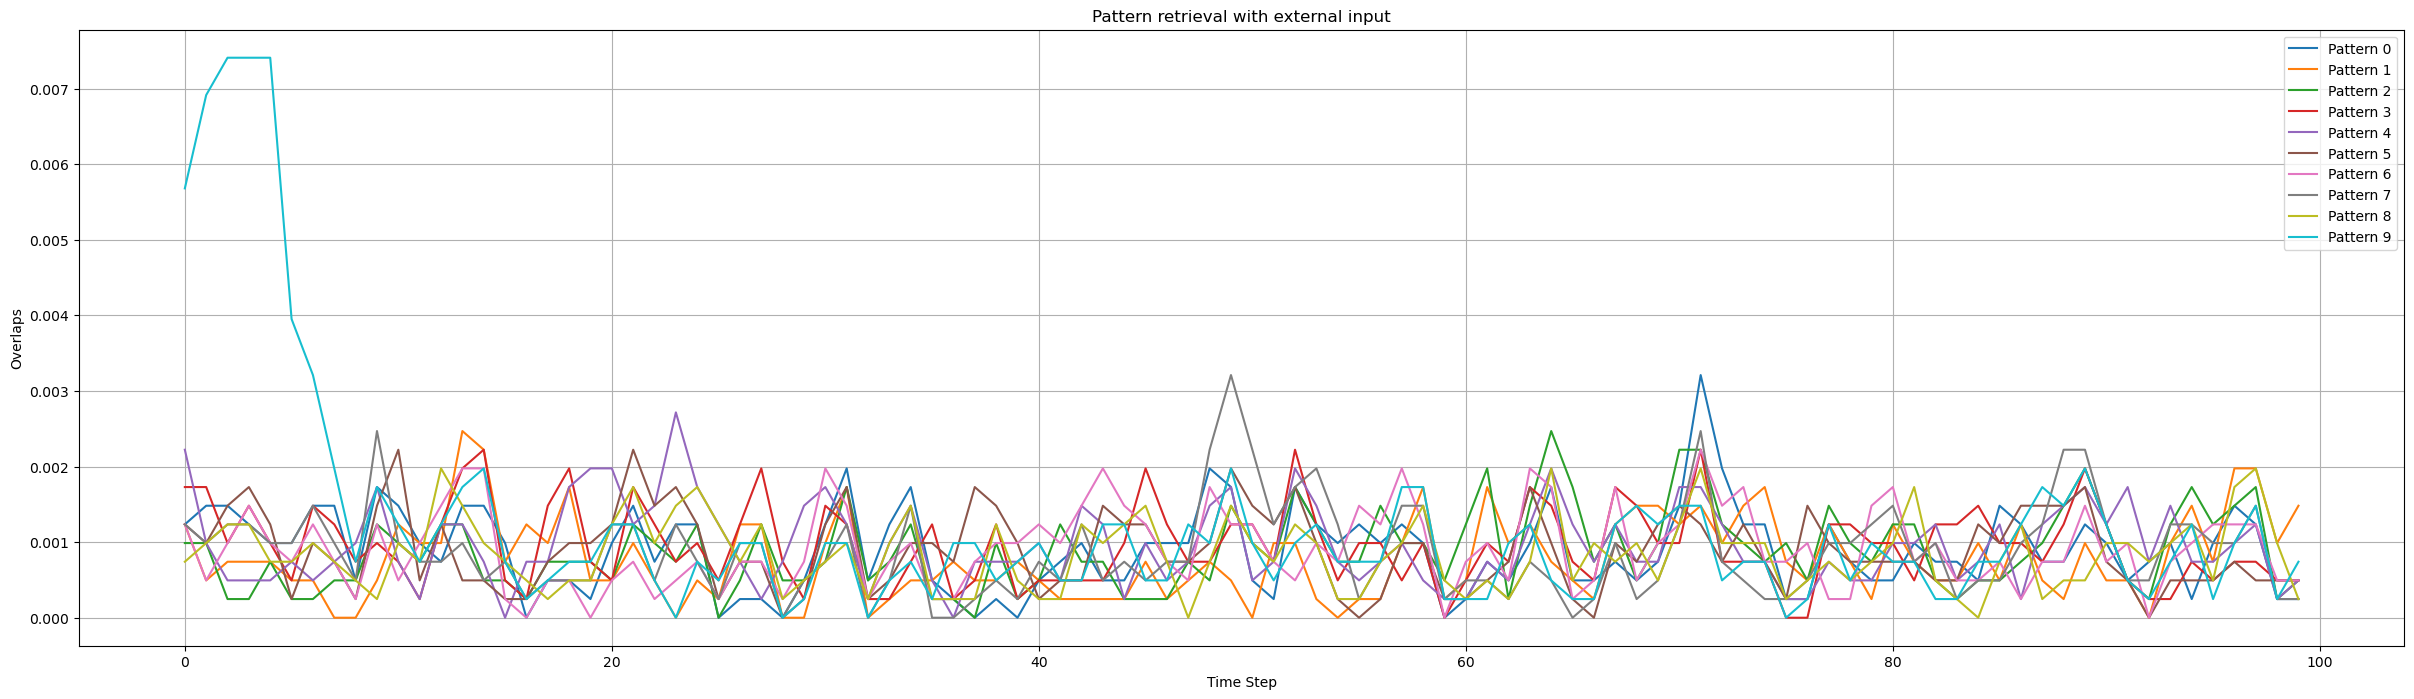

In [280]:
overlaps_sync = np.array(results_sync_with_input["overlaps"])
overlaps_async = np.array(results_async_with_input["overlaps"])
print(results_sync_with_input["overlaps"].shape)
print(results_async_with_input["overlaps"].shape)

# Plotting the overlaps
plt.figure(figsize=(30, 8))
for i in range(overlaps_sync.shape[0]):
    #plt.plot(results_async_with_input["overlaps"][i], label=f'Pattern {i+1}')
    plt.plot(results_sync_with_input["overlaps"][i], label=f'Pattern {i}')
plt.xlabel('Time Step')
plt.ylabel('Overlaps')
plt.title('Pattern retrieval with external input')
plt.legend()
plt.grid()
plt.show()

In [169]:
# Plotting the raster plot

def plot_neuron_spiking_from_array(neuron_spikes_exc, neuron_spikes_inh, title1, title2):
    """
    Plots a raster plot of neuron spiking activity from a binary array.

    Args:
        neuron_spikes (numpy array): Array of shape (time_steps, neuron_states) where each element is either 0 or 1.
    """
    # Setting up the figure and axis
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    num_neurons_exc = neuron_spikes_exc.shape[1]
    time_steps_exc = neuron_spikes_exc.shape[0]

    num_neurons_inh = neuron_spikes_inh.shape[1]
    time_steps_inh = neuron_spikes_inh.shape[0]
    
    # Iterate over each neuron
    for neuron_idx in range(num_neurons_exc):
        # Extract spike times for this neuron
        spike_times = np.where(neuron_spikes_exc[:, neuron_idx] == 1)[0]
        # Plot each spike time for the current neuron
        ax[0].plot(spike_times, [neuron_idx] * len(spike_times), 'b|', markersize=1)

    ax[0].set_xlim(0, time_steps_exc)
    ax[0].set_ylim(-1, num_neurons_exc)
    ax[0].set_xlabel('Time Steps')
    ax[0].set_ylabel('Neuron Index')
    ax[0].set_title(title1)

    for neuron_idx in range(num_neurons_inh):
        # Extract spike times for this neuron
        spike_times = np.where(neuron_spikes_inh[:, neuron_idx] == 1)[0]
        # Plot each spike time for the current neuron
        ax[1].plot(spike_times, [neuron_idx] * len(spike_times), 'b|', markersize=1)

    ax[1].set_xlim(0, time_steps_inh)
    ax[1].set_ylim(-1, num_neurons_inh)
    ax[1].set_xlabel('Time Steps')
    ax[1].set_ylabel('Neuron Index')
    ax[1].set_title(title2)
    plt.show()

def plot_raster(activity_matrix, title):
    """
    Plots a raster plot of neuron activity.

    Args:
        activity_matrix (np.array): A 2D array where rows are neurons and columns are time steps.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(activity_matrix, aspect='auto', cmap='Greys', interpolation='none')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Neurons')
    ax.set_title(title)
    plt.show()


(1000, 300)


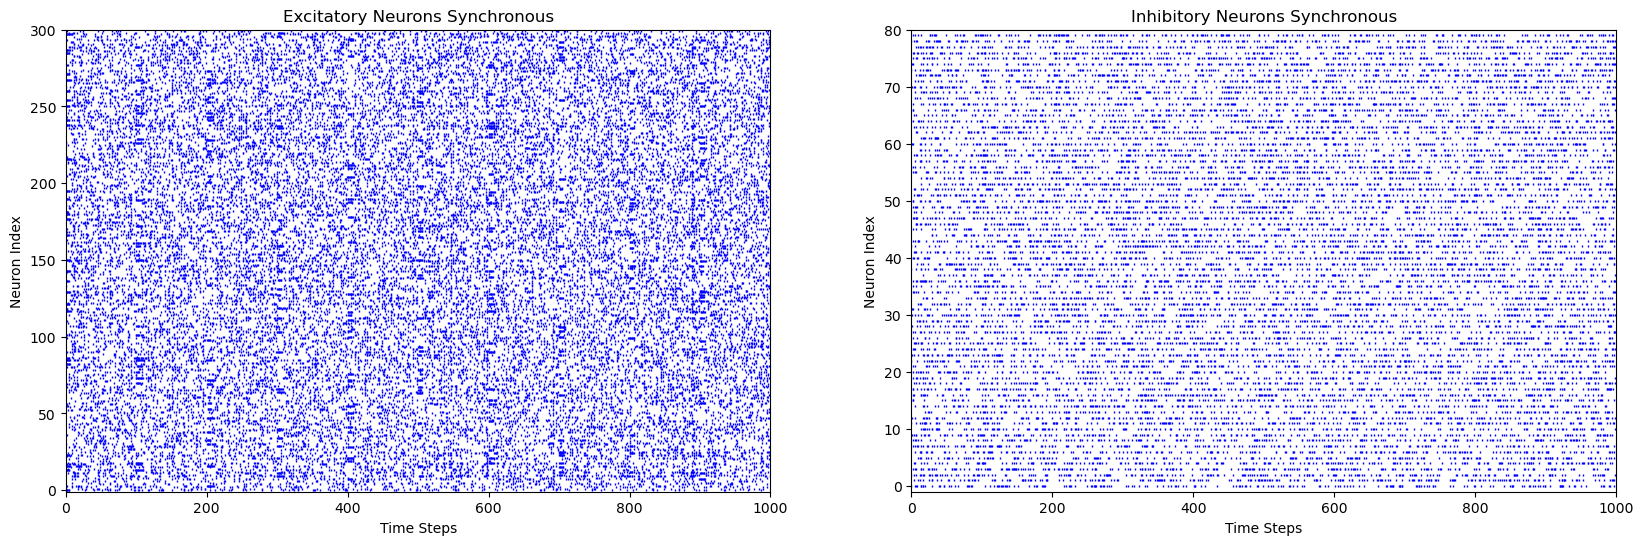

In [171]:
excitatory_states_sync = np.array(results_sync_with_input["excitatory_states"])
excitatory_states_async = np.array(results_async_with_input["excitatory_states"])
print(excitatory_states_async.shape)

inhibitory_states_sync = np.array(results_sync_with_input["inhibitory_states"])
inhibitory_states_async = np.array(results_async_with_input["inhibitory_states"])

plot_neuron_spiking_from_array(excitatory_states_sync,inhibitory_states_sync, title1='Excitatory Neurons Synchronous', title2='Inhibitory Neurons Synchronous')

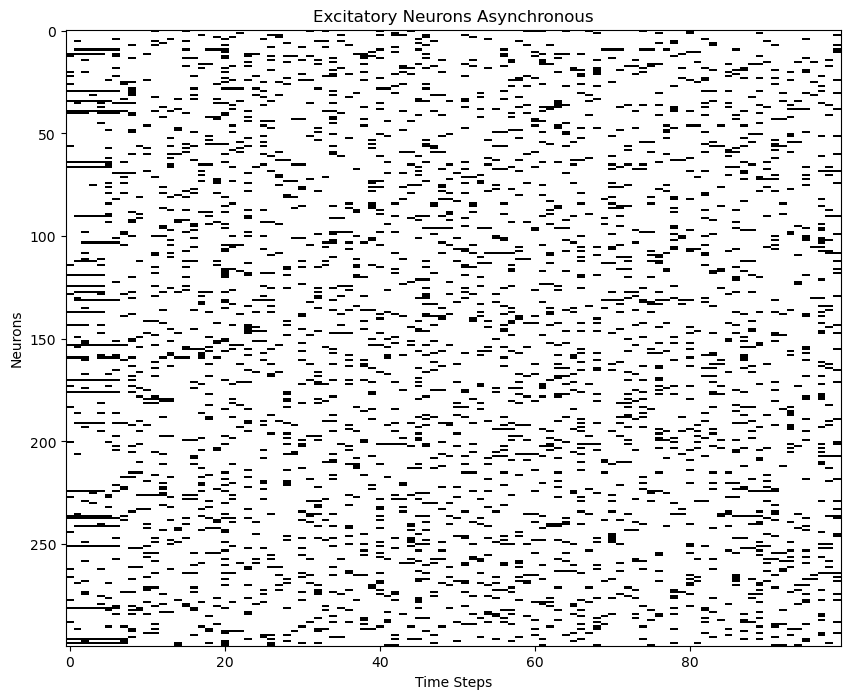

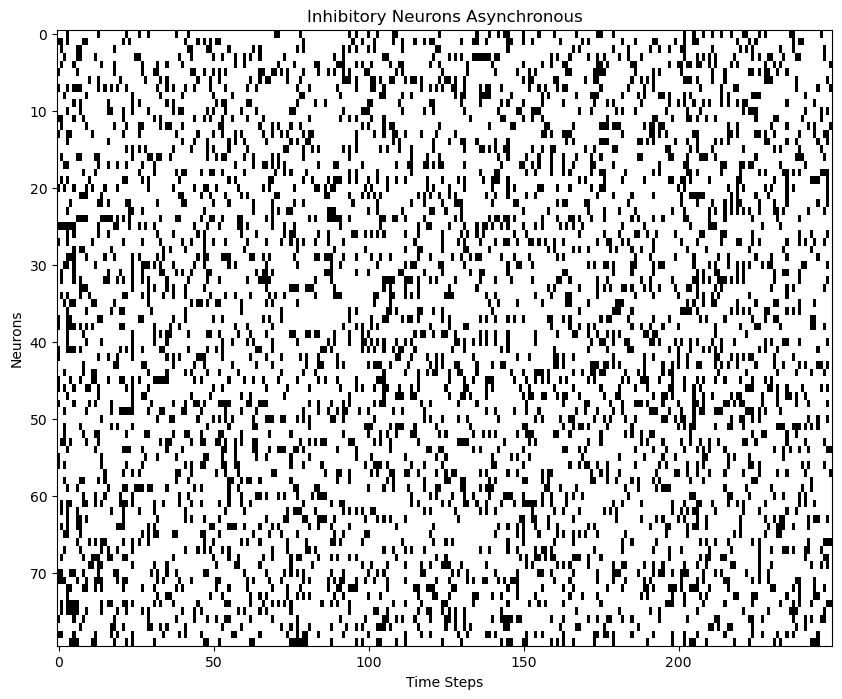

[[1 0 1 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 1 0 0]
 [0 0 1 ... 1 1 0]]


In [173]:
plot_raster(excitatory_states_async.T[:,:100], title='Excitatory Neurons Asynchronous') 
plot_raster(inhibitory_states_async.T[:,:250], title='Inhibitory Neurons Asynchronous')

print(inhibitory_states_sync)

**CHECK THE ASYNCHRONOUS UPDATE**